# Check MWDC position resolutions
Input parquet file should be the output of `mwdc_processor.py` output without --output-wire-data option. <br>
All the shifts parameters needs to be adjusted before checking this notebook.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master("local[10]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

df = spark.read.parquet("parquet/run1039_mwdc.parquet")
df.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/15 23:21:11 WARN Utils: Your hostname, gpuana02, resolves to a loopback address: 127.0.1.1; using 192.168.1.216 instead (on interface enp4s0)
26/01/15 23:21:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/15 23:21:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/15 23:21:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/01/15 23:21:12 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
26/01/15 23:21:12 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
26/01/15 23:21:12 WARN Utils: Se

+---------+-----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+-----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+-----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------------+-------------------+------------------+-------------------+-------+
|hbfNumber| dc31_x1_dl|dc31_x1_id0|dc31_x1_charge0|dc31_x1_timing0|dc31_x2_dl|dc31

## Plot x-y images for each plane

[('dc31_x1_posi', 'dc31_y1_posi'), ('dc31_x2_posi', 'dc31_y2_posi'), ('dc31_x3_posi', 'dc31_y3_posi'), ('dc31_x4_posi', 'dc31_y4_posi'), ('dc32_x1_posi', 'dc32_y1_posi'), ('dc32_x2_posi', 'dc32_y2_posi')]
Statistics:
[[0.000e+00 4.200e+01 0.000e+00]
 [0.000e+00 3.578e+04 2.000e+00]
 [0.000e+00 0.000e+00 0.000e+00]]
Statistics:
[[0.0000e+00 0.0000e+00 0.0000e+00]
 [1.5000e+01 3.5787e+04 0.0000e+00]
 [1.0000e+00 4.6000e+01 0.0000e+00]]
Statistics:
[[0.000e+00 3.800e+01 0.000e+00]
 [0.000e+00 3.578e+04 2.000e+00]
 [0.000e+00 0.000e+00 0.000e+00]]
Statistics:
[[0.0000e+00 0.0000e+00 0.0000e+00]
 [2.5000e+01 3.5708e+04 0.0000e+00]
 [0.0000e+00 4.7000e+01 0.0000e+00]]
Statistics:
[[0.0000e+00 2.5000e+01 0.0000e+00]
 [0.0000e+00 3.5802e+04 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00]]
Statistics:
[[0.0000e+00 0.0000e+00 0.0000e+00]
 [8.0000e+00 3.5745e+04 0.0000e+00]
 [0.0000e+00 1.0000e+00 0.0000e+00]]


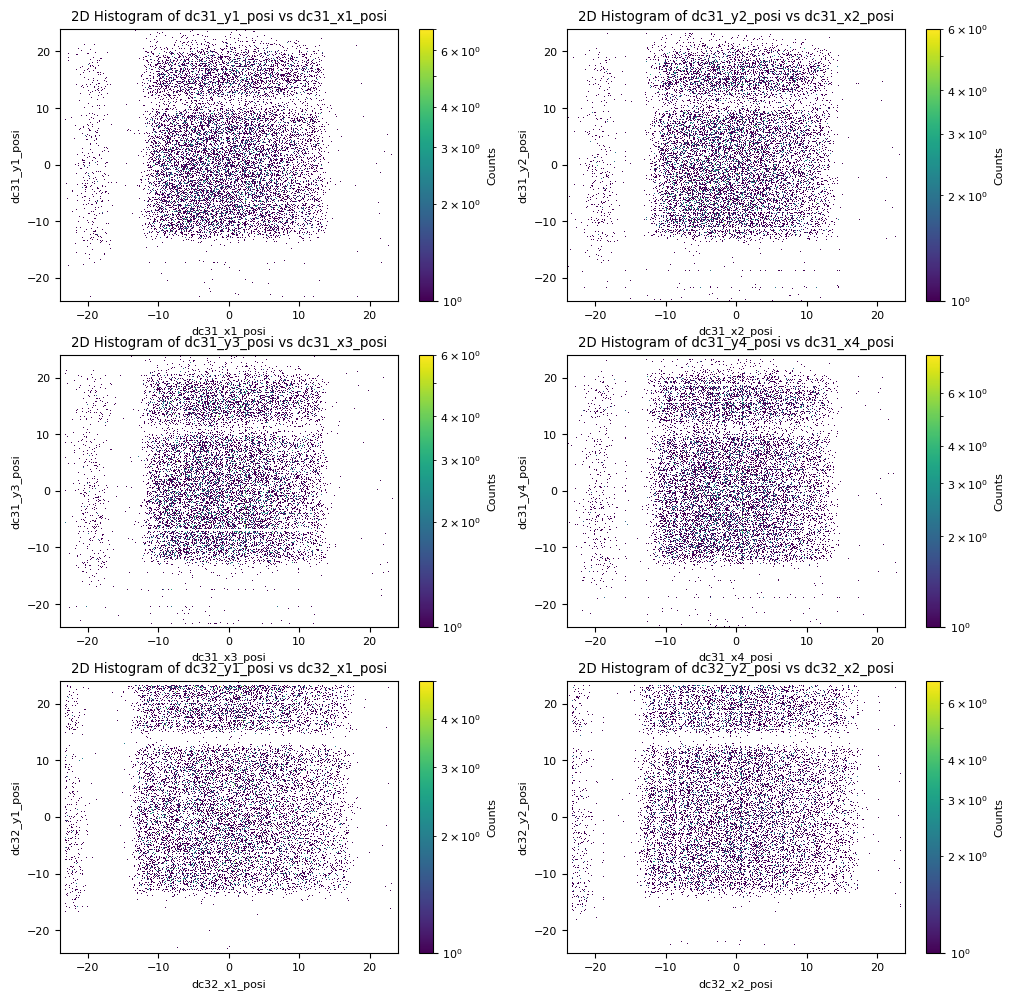

In [2]:
from matplotlib import pyplot as plt
from hist.sparkHist2d import Hist2D
from matplotlib.colors import LogNorm


planes = [(f"dc31_x{x}_posi", f"dc31_y{x}_posi") for x in range(1,5)]
planes = planes + [(f"dc32_x{x}_posi", f"dc32_y{x}_posi") for x in range(1,3)]
print(planes)
plt.figure(0, figsize=(12,12))
plt.rcParams["font.size"] = 8
for i, plane in enumerate(planes):
    q, mod = divmod(i,2)
    plt.subplot2grid((3,2),(q,mod))
    d = Hist2D(df, [plane[0],plane[1]],[500,500],[[-24,24],[-24,24]],  interpolation='none', norm=LogNorm())
plt.show()

## DC31 position resolution
= errors on `dc31_x_posi` and `dc31_y_posi` in sigma

Number of events: 36014
Total entries: 36139, Underflow: 460, Inside: 34883, Overflow: 796
Total entries: 36361, Underflow: 682, Inside: 35107, Overflow: 572
Total entries: 36196, Underflow: 517, Inside: 34947, Overflow: 732
Total entries: 36437, Underflow: 758, Inside: 35196, Overflow: 483


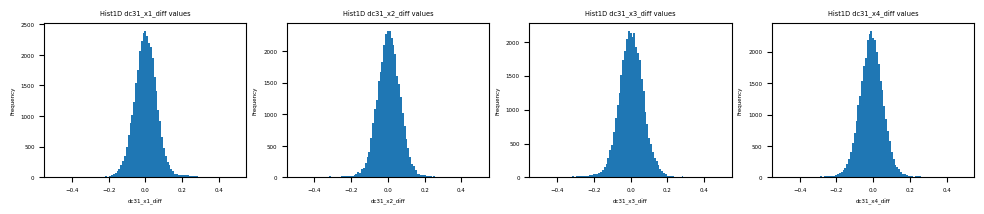

[0.07726642274543491, 0.0782155697899991, 0.08224136635008551, 0.0784269963288676]
DC31 x-plane resolution: 34.2 um
Total entries: 36070, Underflow: 369, Inside: 35047, Overflow: 654
Total entries: 36343, Underflow: 642, Inside: 35333, Overflow: 368
Total entries: 36109, Underflow: 408, Inside: 35106, Overflow: 595
Total entries: 36298, Underflow: 597, Inside: 35276, Overflow: 425


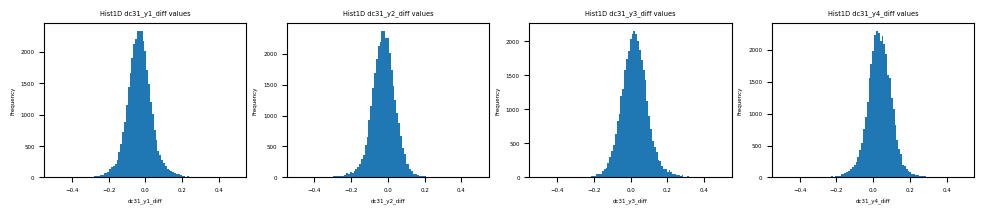

[0.08550900899922338, 0.07851745337506794, 0.08301488968139668, 0.08412475000193084]
DC31 y-plane resolution: 35.9 um


In [3]:
import math

from hist.sparkHist1d import Hist1D
planes = ["x", "y"]

n = df.count()
print(f"Number of events: {n}")
for plane in planes:
    dc31_planes = [f"dc31_{plane}{x}" for x in range(1,5)]

    df_avg = df.withColumn(f"dc31_{plane}_avg", sum(F.col(x+"_posi") for x in dc31_planes)/len(dc31_planes))
    stdevs = []
    plt.figure(0, figsize=(12,2))
    plt.rcParams["font.size"] = 4
    for i, pl in enumerate(dc31_planes):
        df_std = df_avg.withColumn(f"{pl}_diff", F.col(f"{pl}_posi") - F.col(f"dc31_{plane}_avg"))
        plt.subplot2grid((1,4),(0,i))
        h = Hist1D(df_std, f"{pl}_diff", 100, [-0.5, 0.5])
        df_std = df_std.filter(f"ABS({pl}_diff) < 0.8")
        df_std = df_std.withColumn(f"{pl}_resol", F.col(f"{pl}_diff")*F.col(f"{pl}_diff"))
        stdevs.append(df_std.select(F.sum(f"{pl}_resol")).collect()[0][0]/n)
    plt.show()
    print([math.sqrt(x) for x in stdevs])
    npl = float(len(stdevs))
    rms = math.sqrt(sum(stdevs)/npl*(npl-1))/npl
    print(f"DC31 {plane}-plane resolution: {rms*1000:.1f} um")


## DC32 Position Resolution
= errors on `dc32_x_posi` and `dc32_y_posi` in sigma

Number of events: 36014
Total entries: 36944, Underflow: 1114, Inside: 35662, Overflow: 168
Total entries: 35998, Underflow: 168, Inside: 34716, Overflow: 1114


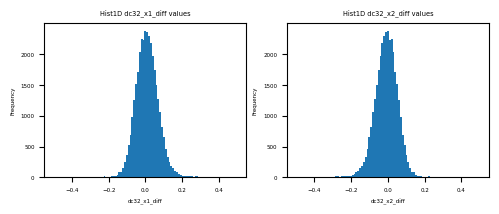

[0.07583227213231392, 0.07583227213231392]
DC32 x-plane resolution: 37.9 um
Total entries: 35980, Underflow: 236, Inside: 35560, Overflow: 184
Total entries: 35928, Underflow: 184, Inside: 35508, Overflow: 236


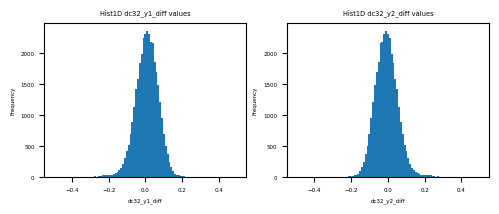

[0.08601377808817372, 0.08601377808817372]
DC32 y-plane resolution: 43.0 um


In [4]:
planes = ["x", "y"]

n = df.count()
print(f"Number of events: {n}")
for plane in planes:
    dc32_planes = [f"dc32_{plane}{x}" for x in range(1,3)]

    df_avg = df.withColumn(f"dc32_{plane}_avg", sum(F.col(x+"_posi") for x in dc32_planes)/len(dc32_planes))
    stdevs = []
    plt.figure(0, figsize=(12,2))
    plt.rcParams["font.size"] = 4
    for i, pl in enumerate(dc32_planes):
        df_std = df_avg.withColumn(f"{pl}_diff", F.col(f"{pl}_posi") - F.col(f"dc32_{plane}_avg"))
        plt.subplot2grid((1,4),(0,i))
        h = Hist1D(df_std, f"{pl}_diff", 100, [-0.5, 0.5])
        df_std = df_std.filter(f"ABS({pl}_diff) < 0.8")
        df_std = df_std.withColumn(f"{pl}_resol", F.col(f"{pl}_diff")*F.col(f"{pl}_diff"))
        stdevs.append(df_std.select(F.sum(f"{pl}_resol")).collect()[0][0]/n)
    plt.show()
    print([math.sqrt(x) for x in stdevs])
    npl = len(stdevs)
    rms = math.sqrt(sum(stdevs)/npl*(npl-1))/npl
    print(f"DC32 {plane}-plane resolution: {rms*1000:.1f} um")